In [4]:
import logging
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pathlib
from  isotools import Transcriptome
import isotools
logger=logging.getLogger('isotools')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger.info(f'This is isotools version {isotools.__version__}')


INFO:This is isotools version 0.3.3


In [5]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
table_path=f'{out_path}/04_differential_splicing/tables'
plot_path=f'{out_path}/04_differential_splicing/plots'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [6]:
# set plot parameters
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["font.size"]=8
plt.rcParams["font.family"]='sans-serif'#"Times New Roman"
plt.rcParams['figure.dpi']=200


## Load isoseq data

In [7]:

isoseq=Transcriptome.load(f'{out_path}/01_transcriptome/golong_all_{date}_isotools_sparse.pkl')


INFO:loading transcriptome from /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/01_transcriptome/golong_all_2022_12_isotools_sparse.pkl


In [6]:
# define group and sample colors

groups={k:v for k,v in isoseq.groups().items() if k[:3] in ['CLL', 'MDS']}

group_dict={sa:gn for gn,sa_list in isoseq.groups().items() for sa in sa_list}
group_num={sa:i for i,sa in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}

groups['CL_wt']=[sa for gr in ['K562_wt', 'Nalm6_wt'] for sa in isoseq.groups()[gr]]
groups['CL_mut']=[sa for gr in ['K562_mut', 'Nalm6_mut'] for sa in isoseq.groups()[gr]]
groups['B-cell']=isoseq.groups()['B-cell']
group_idx={gn:[i for i,sa in enumerate(isoseq.samples) if sa in grp] for gn,grp in groups.items()}

#groups['GM12878_ENCODE']=isoseq.groups()['GM12878']
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']

sample_colors={sa:group_colors[k] for sa in isoseq.samples for k,v in groups.items() if sa in v }
sample_colors={sa:sample_colors.get(sa,'#003C30') for sa in isoseq.samples}
sample_colors['reference']=group_colors['other']

groups_CL={k:v for k,v in groups.items() if k[:3] in ['CL_', 'GM1']}
groups_CLL={k:v for k,v in groups.items() if k in ['CLL_wt', 'CLL_mut', 'B-cell']}
groups_MDS={k:v for k,v in groups.items() if k in ['MDS_wt', 'MDS_mut', 'B-cell']}

group_same_colors={k:group_colors["all_"+k.split("_")[1]] for k in group_colors if 'wt' in k or 'mut' in k}
group_same_colors['B-cell']=group_colors['B-cell']


## differential splicing

In [18]:
gr=isoseq.groups()
gr.update({'all_mut':gr['CLL_mut']+gr['MDS_mut']+gr['K562_mut']+gr['Nalm6_mut'],'all_wt':gr['CLL_wt']+gr['MDS_wt']+gr['K562_wt']+gr['Nalm6_wt']})
gr.update({'CL_mut':gr['K562_mut']+gr['Nalm6_mut'],'CL_wt':gr['K562_wt']+gr['Nalm6_wt']})
# gr.update({'pat_mut':gr['CLL_mut']+gr['MDS_mut'],'pat_wt':gr['CLL_wt']+gr['MDS_wt']})


In [19]:
isoseq.sample_table

,name,file,group,nonchimeric_reads,chimeric_reads,internal_id,phenotype,genotype,platform,TSM_ID,sample_pool,DNA_smear,illumina_sample_id,SF3B1_mut,SF3B1_AF
0,K01,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_wt,694647,314,K562_wt_1,K562,wt,S2,D001,1-1,2828.0,MRS938,,
0,K02,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_wt,525087,540,K562_wt_2,K562,wt,S2,D002,1-1,2692.0,MRS940,,
0,K03,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_mut,874809,880,K562_mut_1,K562,mut,S2,D003,1-1,3036.0,MRS939,p.Lys700Glu,41.0
0,K04,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_mut,795126,709,K562_mut_2,K562,mut,S2,D004,1-1,2940.0,MRS941,p.Lys700Glu,45.0
0,N01,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_wt,545784,151,Nalm6_wt_1,Nalm6,wt,S2,D005,1-2,3054.0,MRS942,,
0,N02,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_wt,355818,63,Nalm6_wt_2,Nalm6,wt,S2,D006,1-2,3119.0,MRS944,,
0,N03,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_mut,635575,640,Nalm6_mut_1,Nalm6,mut,S2,D007,1-2,3197.0,MRS943,p.His662Gln,28.0
0,N04,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_mut,859604,154,Nalm6_mut_2,Nalm6,mut,S2,D008,1-2,3292.0,MRS945,p.His662Gln,29.0
0,C01,/project/42/pacbio/golong/05d-raw_align_mm2/25...,CLL_wt,676483,954,CLL171,CLL,wt,S2,25-10,2-1,2753.0,MRS621,,
0,C02,/project/42/pacbio/golong/05d-raw_align_mm2/25...,CLL_wt,460625,306,CLL113,CLL,wt,S2,25-11,2-1,2191.0,MRS611,,


In [20]:
do_compute=False

res={}
version='less_strict'
from tqdm import tqdm
noORF=(None, None, {'NMD':False})
groups_test={}
print(version)
for diff_cmp in ["all", "CL","CLL",'MDS']:
    groups_test[diff_cmp]={f'{diff_cmp}_{gt}':gr[f'{diff_cmp}_{gt}'] for gt in ['mut', 'wt']}
    #takes about 50/25/39/33 min per test
    if do_compute:
        if version=='less_strict':
            res[diff_cmp]=isoseq.altsplice_test(groups_test[diff_cmp],test='betabinom_lr',min_sa=4, min_alt_fraction=.05).sort_values('pvalue')  # 4 samples per group at least 10 reads
        else:
            res[diff_cmp]=isoseq.altsplice_test(groups_test[diff_cmp],test='betabinom_lr').sort_values('pvalue')  #51% samples per group at least 10 reads
        res[diff_cmp].insert(list(res['all'].columns).index('nmdB')+1, 'nmdDiff', abs(res['all']['nmdA']-res['all']['nmdB']))
        res[diff_cmp].to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_{diff_cmp}.csv', index=False)
        res[diff_cmp].loc[res[diff_cmp].padj<.1].sort_values('padj').to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_{diff_cmp}_significant.csv', index=False)
    else:
        res[diff_cmp]=pd.read_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_{diff_cmp}.csv')
        res[diff_cmp]['trA']=res[diff_cmp]['trA'].str[1:-1].str.split(',').apply(lambda x:[int(i) for i in x])
        res[diff_cmp]['trB']=res[diff_cmp]['trB'].str[1:-1].str.split(',').apply(lambda x:[int(i) for i in x])
    sig=res[diff_cmp].padj<.1
    print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups_test[diff_cmp])}')


less_strict
782 differential splice sites in 531 genes for all_mut vs all_wt
83 differential splice sites in 63 genes for CL_mut vs CL_wt
286 differential splice sites in 205 genes for CLL_mut vs CLL_wt
218 differential splice sites in 176 genes for MDS_mut vs MDS_wt


In [21]:
splice_types=['ES','IR','ME','3AS','5AS']
for diff_cmp in ["all", "CL","CLL",'MDS']:
    sig=res[diff_cmp].padj<.1
    n=res[diff_cmp].splice_type.value_counts()
    n_sig=res[diff_cmp].loc[sig].splice_type.value_counts()
    genes=res[diff_cmp].loc[sig].query('splice_type in @splice_types')["gene"].unique()
    n_diff=sum(n_sig.get(st,0) for st in splice_types)
    print(f'{n_diff} differential splice sites in {len(genes)} genes for {" vs ".join(groups_test[diff_cmp])}')
    
    print(f'{n_sig["3AS"]/n_diff:.2%} of all differential splice sites in {" vs ".join(groups_test[diff_cmp])} ')

649 differential splice sites in 461 genes for all_mut vs all_wt
50.69% of all differential splice sites in all_mut vs all_wt 
70 differential splice sites in 59 genes for CL_mut vs CL_wt
80.00% of all differential splice sites in CL_mut vs CL_wt 
227 differential splice sites in 170 genes for CLL_mut vs CLL_wt
51.98% of all differential splice sites in CLL_mut vs CLL_wt 
172 differential splice sites in 152 genes for MDS_mut vs MDS_wt
61.63% of all differential splice sites in MDS_mut vs MDS_wt 


In [16]:
deseq_res=pd.read_csv('/project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/DESeq/golong_all_2022_12_DESeq_MDS_CLL.csv').set_index('Unnamed: 0')
deseq_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Unnamed: 0,,,,,,
ENSG00000196565.15,238.271911,27.198587,1.133437,23.996554,3.020946e-127,4.822337e-123
ENSG00000102445.20,661.545717,-6.971521,0.299852,-23.249847,1.427618e-119,1.139454e-115
ENSG00000244734.4,11254.447227,16.994827,0.776719,21.880274,4.004279e-106,2.130677e-102
ENSG00000204103.4,198.690251,27.849361,1.319005,21.113922,5.924622e-99,2.364368e-95
ENSG00000135046.14,935.231554,12.084256,0.572913,21.092643,9.292294e-99,2.966658e-95
...,...,...,...,...,...,...
ENSG00000106144.20,29.093600,1.719109,0.595387,2.887382,NaN,NaN
ENSG00000160999.10,1.123835,1.714948,1.312224,1.306902,NaN,NaN
ENSG00000134013.16,3.983586,0.408484,1.593862,0.256286,NaN,NaN


In [27]:
# get differential expressed genes overlapping with 3AS

total_reads=isoseq.sample_table.set_index('name')['nonchimeric_reads']
diff_cmp='all'
logFCth=np.log2(2)
sig=res[diff_cmp].padj<.1
goi=res[diff_cmp].loc[sig,"gene"].unique()
expression_logFC={}
padj={}
de_genes=set()
for gname in goi:
    g=isoseq[gname]
    # tpm=g.coverage.sum(1)/total_reads*1e6+.1
    # expression_logFC[gname]=np.log2(tpm[groups['MDS_wt']].mean()/tpm[groups['CLL_wt']].mean())
    expression_logFC[gname]=deseq_res.loc[g.id, 'log2FoldChange']
    padj[gname]=deseq_res.loc[g.id, 'padj']
    if (abs(expression_logFC[gname])>=logFCth) and padj[gname]< .1:
        de_genes.add(gname)
        
print(f'{len(de_genes)}/{len(goi)} genes have > {2**logFCth} fold expression difference between CLL and MDS wt')
print(f'{len([g for g,lfc in expression_logFC.items() if lfc > logFCth])} up in MDS')
print(f'{len([g for g,lfc in expression_logFC.items() if lfc < -logFCth])} up in CLL')

297/531 genes have > 2.0 fold expression difference between CLL and MDS wt
149 up in MDS
155 up in CLL


In [28]:
print('MDS')
print([g for g,lfc in expression_logFC.items() if lfc > logFCth])
print('CLL')
print([g for g,lfc in expression_logFC.items() if lfc < -logFCth])

MDS
['TMEM14C', 'NET1', 'FAR2', 'USP15', 'ENOSF1', 'TOR1AIP2', 'PIP5K1B', 'DYNLL1', 'ZFAND5', 'MYL4', 'SLC36A4', 'BUB1B', 'RDX', 'COASY', 'GEN1', 'TPT1', 'DNAJC3', 'EI24', 'S100A8', 'SNHG29', 'LRRCC1', 'TTK', 'ECT2', 'SYF2', 'STIM1', 'ORAI2', 'TFRC', 'HELLS', 'PPM1M', 'MYCBP', 'KANSL3', 'SYVN1', 'LYZ', 'MINDY4', 'STXBP2', 'TMCC2', 'PSTPIP1', 'INTS13', 'SELENBP1', 'ARHGAP9', 'ACSL1', 'C1D', 'HIF1A', 'TBC1D15', 'RPL27A', 'EIF3E', 'NUCB2', 'NAIP', 'CITED2', 'BRCA1', 'TNIP1', 'ABTB1', 'TNFAIP3', 'TREM1', 'IRAK3', 'PDLIM7', 'TMEM214', 'TLR2', 'CDC7', 'UROD', 'GCA', 'HSPBP1', 'RPL24', 'UBA7', 'BCL2L1', 'TMEM63A', 'PPOX', 'TCF7L2', 'UBAP1', 'TFEC', 'TPX2', 'AC022400.6', 'HLA-A', 'MECOM', 'RALGAPA2', 'CXXC1', 'METTL5', 'GPX1', 'CKAP2', 'STK16', 'CD300LF', 'UCHL5', 'BAZ1A', 'IVNS1ABP', 'LINC01410', 'FERMT3', 'DGCR2', 'AC079466.1', 'CCNC', 'PSMC6', 'NT5C3A', 'STAT4', 'CTNNAL1', 'MRPS9', 'SGO2', 'ANLN', 'SLC2A3', 'MICAL1', 'CROCCP2', 'STIL', 'GPR171', 'MID1IP1', 'AC254945.2', 'TANGO2', 'PBXIP1', 

In [10]:
pd.set_option("display.max_columns", None)
#res['all'][res['all'].padj<.01].sort_values('nmdDiff', ascending=False).head(40)

/home/lienhard/.local/lib/python3.10/site-packages/isotools/plots.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plotted = plotted.append(row)
/home/lienhard/.local/lib/python3.10/site-packages/isotools/plots.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plotted = plotted.append(row)
/home/lienhard/.local/lib/python3.10/site-packages/isotools/plots.py:92: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  plotted = plotted.append(row)
/home/lienhard/.local/lib/python3.10/site-packages/isotools/plots.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plotted = plotted.append(row)
/home/li

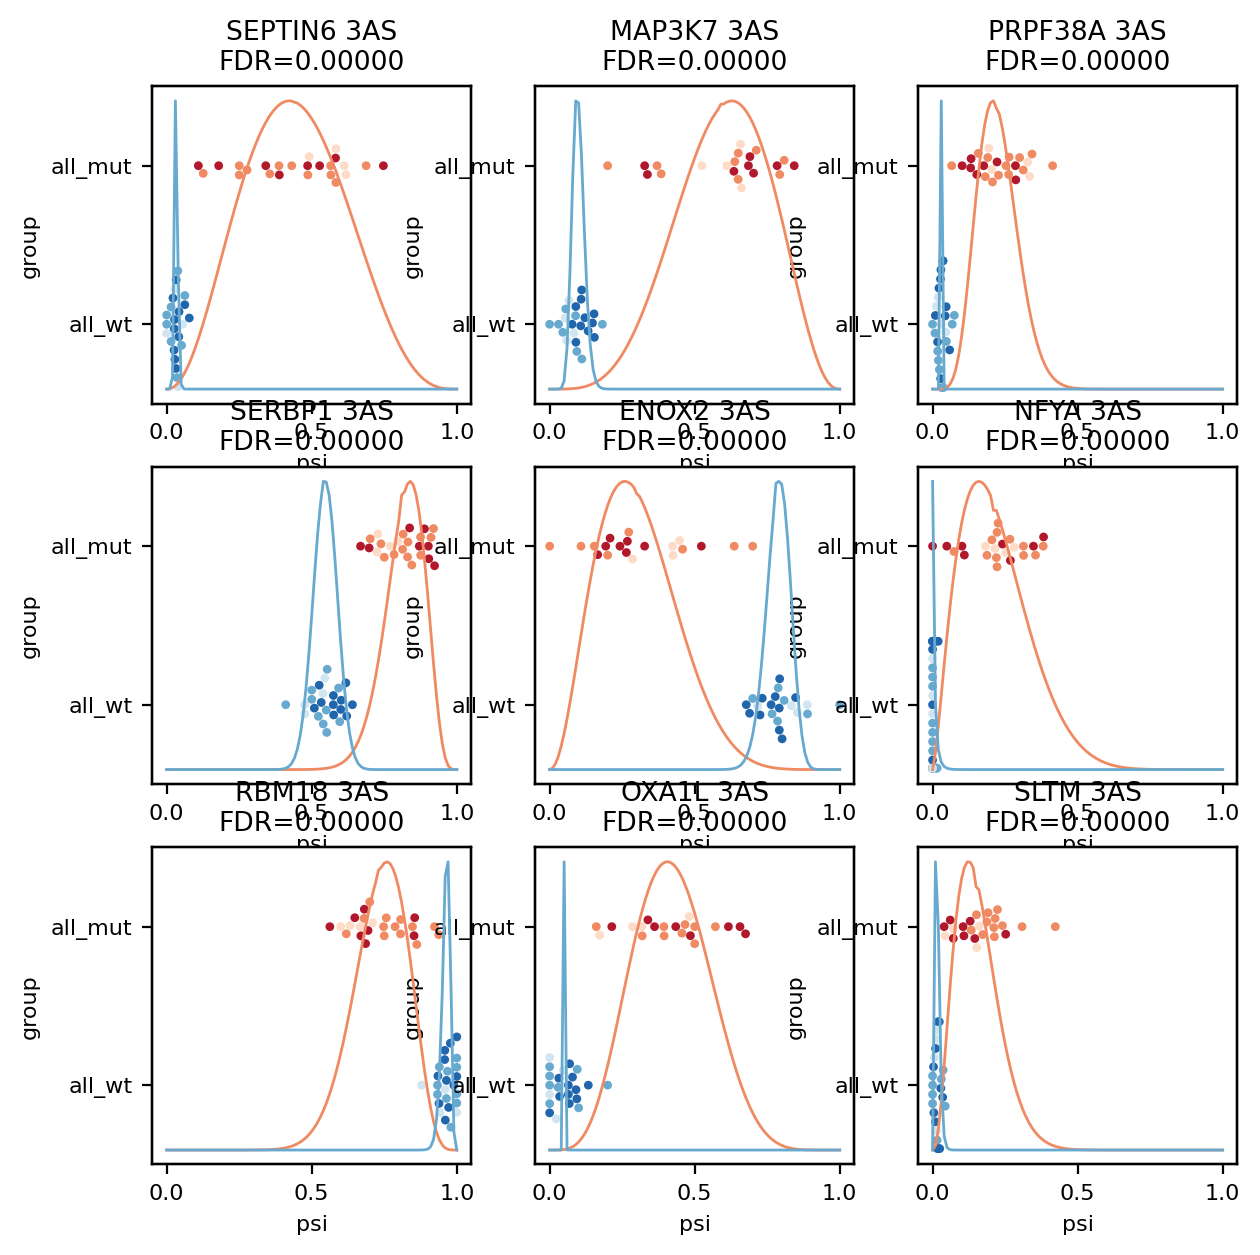

In [10]:
# plot the top differential events
from isotools.plots import plot_diff_results
plt.rcParams["figure.figsize"] = (7,7)
for diff_cmp in res:
    f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(3,3), group_colors=group_colors, sample_colors=sample_colors, lw=1,pt_size=10 )
    f.savefig(f'{plot_path}/{project}_{date}_diff_betabinomial_{version}_{diff_cmp}.pdf')
    if diff_cmp != 'all':
        plt.close(f)
    plotted.to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_plot_{diff_cmp}.csv', index=False)

In [11]:
for diff_cmp in res:
    res[diff_cmp]=res[diff_cmp].reset_index(drop=True)

/home/lienhard/.local/lib/python3.10/site-packages/isotools/plots.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plotted = plotted.append(row)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 34.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/lienhard/.local/lib/python3.10/site-packages/isotools/plots.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plotted = plotted.append(row)
/home/lienhard/.local/lib/python3.10/site-packages/isotools/plots.py:92: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  plotted = plotted.append(row)
/pkg/python-3.1

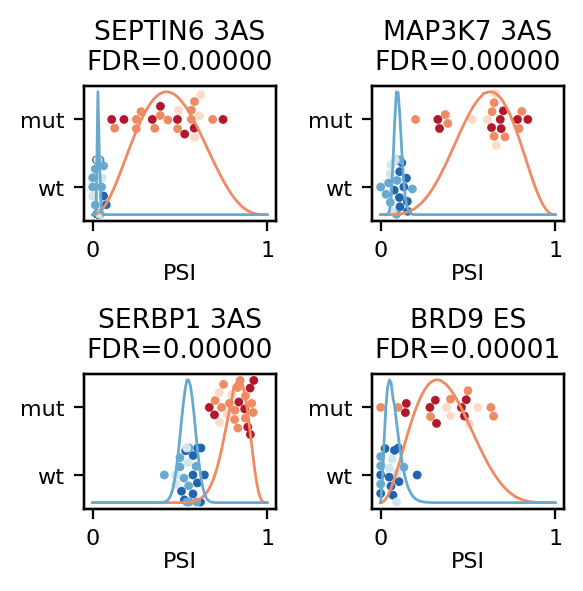

In [12]:
diff_cmp='all'
plt.rcParams["figure.figsize"] = (3,3)

sel_idx=res[diff_cmp].query('gene=="BRD9"').index[0]
res_sel=res[diff_cmp].loc[[0,1,3,sel_idx]]
f,axs,plotted=plot_diff_results(res_sel, min_diff=.1,grid_shape=(2,2), group_colors=group_colors, sample_colors=sample_colors, lw=1,pt_size=10 )
for ax in axs:
    ax.set_xlabel(f'PSI',labelpad=1)
    ax.set_ylabel('',labelpad=-5)
    ax.set_yticklabels(['mut', 'wt'])
f.tight_layout()
f.savefig(f'{plot_path}/{project}_{date}_diff_betabinomial_poster_{version}_{diff_cmp}.pdf')


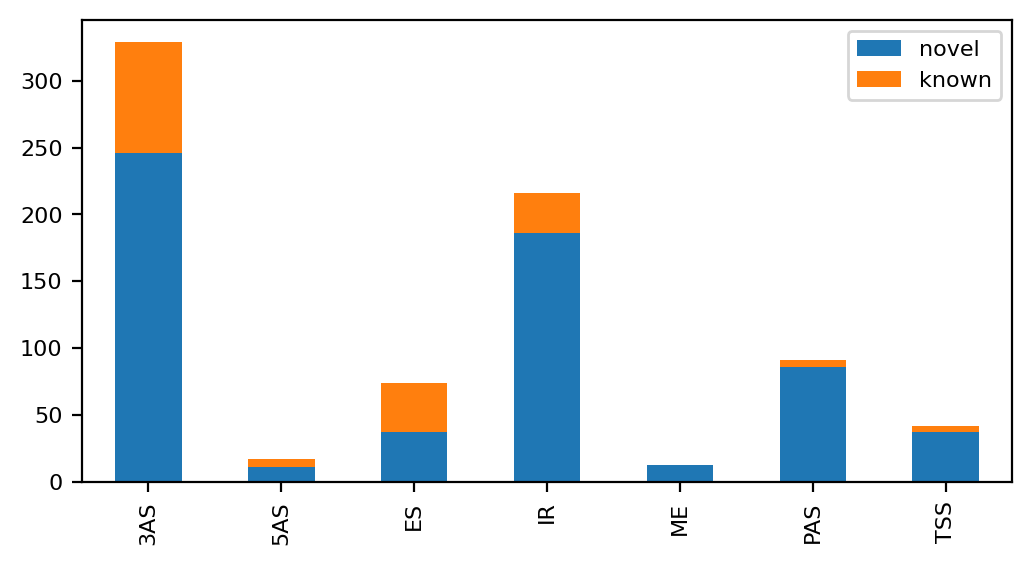

In [13]:
diff_cmp='all'
plt.rcParams["figure.figsize"] = (6,3)

sig=res[diff_cmp].padj<.1
tmp=res[diff_cmp].loc[sig, ['splice_type', 'novel']]
n_type=pd.DataFrame({'novel':tmp.splice_type[tmp.novel].value_counts(), 'known':tmp.splice_type[~tmp.novel].value_counts()}).fillna(0)
#(n_type/n_type.values.sum()*100).plot.bar(stacked=True)
n_type.plot.bar(stacked=True)
plt.savefig(f'{plot_path}/{project}_{date}_difsplice_type_bar.pdf', bbox_inches='tight')


In [14]:
n_type.to_csv(f'{table_path}/{project}_{date}_difsplice_type_bar.csv', sep='\t')

## preprare 3AS events
* Add information of 'alternative' 3AS position - between start (5' splice site on +) and end (other 3AS on +)
* Add information on coding potential, according to reference:
    * coding: at least one coding transcript uses the splice site, within CDS
    * UTR: at least one coding transcript uses the splice site, outside CDS
    * noncoding: at least one noncoding transcript (without CDS) uses the site
    * Novel Acceptor - 3AS not used in reference
    * Novel Gene - no info available


In [15]:
def is_coding(g, pos1, pos2): 
    'return True iff 3AS at pos is part of coding sequence according to reference annotation'
    if not g.is_annotated:
        return 'novel gene'
    sg=g.ref_segment_graph
    strand=g.strand=='-'
    nodes=[(i,n) for i,n in enumerate(sg) if n[strand] in {pos1,pos2}]
    if not nodes:
        return 'novel acceptor'
    res='noncoding'
    for i,n in  nodes:
        troi=[k for k,v in n[strand+2].items() if abs(sg[v][g.strand=='+']-n[strand])>0 ] # all transcripts with "real" junction at pos
        for trnr in troi:
            tr=g.ref_transcripts[trnr]
            if 'CDS' in tr:
                if tr['CDS'][0]<=n[strand]<=tr['CDS'][1]:
                    return 'coding'
                res='UTR'
    return res
    

In [16]:
def get_alternative_threeprime(gene_id,event_start,event_end, strand):
    g=isoseq[gene_id]
    sg=g.segment_graph
    prim, alt,n_start, n_end,t =list(sg.find_splice_bubbles(pos=(event_start, event_end), types='3AS'))[0] #this should be only one for AS
    if strand=='+':
        alt_pos=[(trid, next(e[0] for e in g.transcripts[trid]['exons'] if e[1]> event_end and e[0]<=event_end)) for trid in alt ]
    else:
        alt_pos=[(trid, next(e[1] for e in g.transcripts[trid]['exons'] if e[0]< event_start and e[1]>=event_start)) for trid in alt ]
    alt_pos=pd.DataFrame([(pos,g.coverage[:,trid].sum()) for trid,pos in alt_pos], columns=['pos','n'])
    alt_pos=alt_pos.groupby('pos')['n'].sum()
    return alt_pos.idxmax()

#### Analysis of coding potential:
* select 3'AS events with shift between -21 and -12 and wt PSI < 0.5 (wt prefers longer intron)
* distinguish significant difference (wt/mut)
* check coding potential

In [12]:
# write a table with all 3AS events
res3as={}
for diff_cmp,diff_tab in res.items():
    if not do_compute:
        res3as[diff_cmp]=pd.read_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_3AS_{diff_cmp}.csv')
        continue
    print(diff_cmp)
    as3=diff_tab.loc[diff_tab['splice_type']=="3AS"]
    alt_pos=[]
    for idx,row in as3.iterrows():
        alt_pos.append(get_alternative_threeprime(row.gene_id, row.start, row.end, row.strand))
    as3.insert(5, "alternative", alt_pos)
    
    d=[]
    for strand, start, alt, end, mut, wt in zip(as3.strand, as3.start, as3.alternative, as3.end, as3[diff_cmp+'_mut_PSI'], as3[diff_cmp+'_wt_PSI']):
        d_i=alt-start if strand=='-' else end-alt
        if mut>wt:
            d_i*=-1
        d.append(d_i)
    as3.insert(7, "AS_shift", d)
    as3=as3.sort_values('AS_shift')
    coding=[is_coding(isoseq[row.gene_id], row.start, row.alternative) if row.strand=='-' else is_coding(isoseq[row.gene_id], row.alternative, row.end) for idx,row in as3.iterrows()]
    as3.insert(8, "coding", coding)
    as3.to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_3AS_{diff_cmp}.csv', index=False)
    res3as[diff_cmp]=as3

In [18]:
from isotools._utils import has_overlap
for diff_cmp, as3 in res3as.items():
    if 'NMD1' in as3:
        continue
    print(diff_cmp)
    nmd, orf_len, coding=[],[],[]
    for idx, row in as3.iterrows():
        g=isoseq[row.gene_id]
        trA, trB=row.trA, row.trB
        if isinstance(trA, str):
            trA=list(map(int,trA[1:-1].split(', ')))
        if isinstance(trB, str):
            trB=list(map(int,trB[1:-1].split(', ')))
        trA.sort(key=lambda x:-g.coverage[:,x].sum())
        trB.sort(key=lambda x:-g.coverage[:,x].sum())
        # g.gene_track(select_transcripts=[trA[0], trB[0]], reference=False, x_range=[row.start-100, row.end+100])
        default_orf=(None, None, {'length':0, 'NMD':True})
        orfA, orfB=g.transcripts[trA[0]].get('ORF',default_orf), g.transcripts[trB[0]].get('ORF',default_orf)
        nmd.append((orfA[2]['NMD'], orfB[2]['NMD']))
        orf_len.append((orfA[2]['length'], orfB[2]['length']))
        if orfA==default_orf and orfB==default_orf:
            coding.append("noncoding")
        elif not any (has_overlap(orf, (row.start,row.end)) for orf in [orfA[:2],orfB[:2]] if orf != default_orf[:2]):
            coding.append("UTR")
        elif any (row.start<pos<row.end for pos in orfA[:2]+orfB[:2] if pos):
            coding.append("new_stop")
        elif orf_len[-1][1]==orf_len[-1][0] and orfA[:2]==orfB[:2]:
            coding.append("no_change")
        elif orf_len[-1][1]-orf_len[-1][0] == - row.AS_shift and row.AS_shift%3==0:
            coding.append("in_frame")
        elif row.AS_shift%3!=0:
            coding.append("frame_shift")
        else:
            coding.append("coding")
    as3.insert(7,'NMD1',[n[0] for n in nmd]) # normal (short exon)
    as3.insert(8,'NMD2',[n[1] for n in nmd]) # mut (extended exon)
    as3.insert(9,'ORF_diff',[l[1]-l[0] for l in orf_len]) #mut-wt
    as3.insert(9,'3AS_effect',coding)
    as3.to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_3AS_{diff_cmp}.csv', index=False)
    

all
CL
CLL
MDS


In [19]:
for diff_cmp,as3 in res3as.items():
    print(f'\n=={diff_cmp}==')
    sel=as3.loc[((as3.AS_shift <= -12) & (as3.AS_shift >= -21) & (as3[diff_cmp+'_wt_PSI']<.5))]
    sig=sel.loc[sel.padj<.1]
    print('- selected 3as events with shift >=12 and shift <=21 and wt PSI <.5')    
    print(f'  * {len(sig)} out of {len(sel)} are significant ({len(sig)/len(sel):.2%})' )
    coding={'significant':dict(sig.coding.value_counts()), 'not significant':dict(sel.loc[sel.padj>=.1].coding.value_counts())}
    for cgr in coding:
        print(f'- coding potential ({cgr})')
        for what in ['coding','UTR', 'noncoding', 'novel acceptor', 'novel gene']:
            n=coding[cgr].get(what,0)
            print(f'  * {what}:\t{n}\t({n/sum(coding[cgr].values()):.2%})')
    


==all==
- selected 3as events with shift >=12 and shift <=21 and wt PSI <.5
  * 177 out of 456 are significant (38.82%)
- coding potential (significant)
  * coding:	143	(80.79%)
  * UTR:	23	(12.99%)
  * noncoding:	3	(1.69%)
  * novel acceptor:	8	(4.52%)
  * novel gene:	0	(0.00%)
- coding potential (not significant)
  * coding:	201	(72.04%)
  * UTR:	27	(9.68%)
  * noncoding:	19	(6.81%)
  * novel acceptor:	28	(10.04%)
  * novel gene:	4	(1.43%)

==CL==
- selected 3as events with shift >=12 and shift <=21 and wt PSI <.5
  * 37 out of 179 are significant (20.67%)
- coding potential (significant)
  * coding:	32	(86.49%)
  * UTR:	5	(13.51%)
  * noncoding:	0	(0.00%)
  * novel acceptor:	0	(0.00%)
  * novel gene:	0	(0.00%)
- coding potential (not significant)
  * coding:	120	(84.51%)
  * UTR:	15	(10.56%)
  * noncoding:	3	(2.11%)
  * novel acceptor:	3	(2.11%)
  * novel gene:	1	(0.70%)

==CLL==
- selected 3as events with shift >=12 and shift <=21 and wt PSI <.5
  * 60 out of 272 are significant (

In [20]:
### check (top) isoforms of 3AS events
from isotools._utils import pairwise
diff_cmp='all'
as3=res3as[diff_cmp]
sel=as3.loc[((as3.AS_shift <= -12) & (as3.AS_shift >= -21) & (as3[diff_cmp+'_wt_PSI']<.5))]
sig=sel.loc[sel.padj<.1]
anno=[]
for _, row in sig.iterrows():
    g=isoseq[row.gene_id]
    if isinstance(row.trA, str):
        trA=sorted([int(i) for i in row.trA[1:-1].split(",")], key=lambda x: -g.coverage[:,x].sum(0))[0]  # normal (short exon)
        trB=sorted([int(i) for i in row.trB[1:-1].split(",")], key=lambda x: -g.coverage[:,x].sum(0))[0]  # mut (long exon)
    else:
        trA=sorted(row.trA, key=lambda x: -g.coverage[:,x].sum(0))[0]  # normal (short exon)
        trB=sorted(row.trB, key=lambda x: -g.coverage[:,x].sum(0))[0]  # mut (long exon)
    trA=g.transcripts[trA]
    trB=g.transcripts[trB]
    deltaPSI=row[diff_cmp+'_wt_PSI']-row[diff_cmp+'_mut_PSI']
    if deltaPSI<0: # mut preferes alternative
        if row.strand=='+':
            exons=[[row.end,e] if s==row.alternative else [s,e] for s,e in trB['exons']]
        else:
            exons=[[s,row.start] if e==row.alternative else [s,e] for s,e in trB['exons']]
    else:# mut preferes start/end
        if row.strand=='+':
            exons=[[row.alternative,e] if s==row.end else [s,e] for s,e in trB['exons']]
        else:
            exons=[[s,row.alternative] if e==row.start else [s,e] for s,e in trB['exons']]
            
    assert any(e1!=e2 for e1,e2 in zip(exons, trB['exons']))
    if g.is_annotated:
        anno.append(g.ref_segment_graph.get_alternative_splicing(exons, [])[1])
    else:
        anno.append({'novel gene':[]})
pd.Series([','.join(a) for a in anno]).value_counts()
pd.Series([k for a in anno for k in a]).value_counts()

FSM                     124
novel combination        24
novel exon                9
novel 3' splice site      6
intron retention          6
novel 5' splice site      4
exon skipping             3
novel intronic TSS        3
5' fragment               1
3' fragment               1
dtype: int64

In [21]:
def find_position(pos,exons):
    trlen=0
    for e in exons:
        if e[0]<=pos <=e[1]:
            return trlen+pos-e[0]
        trlen+=(e[1]-e[0])

all


<AxesSubplot: xlabel='relpos', ylabel='Count'>

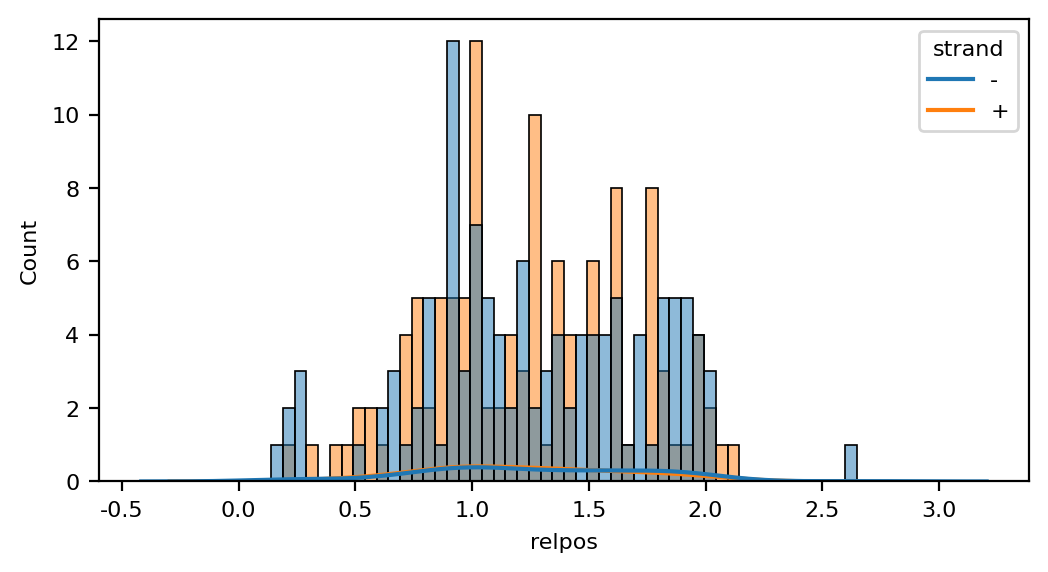

In [22]:
# plot relative position of 3AS events within gene
# relative position is from 0 to 3:
#0-1: within 5'UTR
#1-2: within CDS
#2-3: within 3'UTR
import seaborn as sns
saoi_na=[sa for gn,grp in groups.items() for sa in grp]
saoi=[i for i,sa in enumerate(isoseq.samples) if sa in saoi_na]
diff_cmp='all'
print(diff_cmp)    
as3=pd.read_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_3AS_{diff_cmp}.csv')
relpos_list=[]
for idx, row in as3.query('padj<.01 and AS_shift>=-21 and AS_shift<=-12').iterrows():
    g=isoseq[row.gene_id]
    prim=row.start if row.strand=='-' else row.end
    alt=row.alternative
    #sa=groups[diff_cmp+'_wt']+groups[diff_cmp+'_mut']
    cov=g.coverage[saoi,].sum(0)
    trA=sorted([int(i) for i in row.trA[1:-1].split(',')], key=cov.__getitem__, reverse=True)
    trB=sorted([int(i) for i in row.trB[1:-1].split(',')], key=cov.__getitem__, reverse=True)
    tr_sub=g.filter_transcripts(query='SUBSTANTIAL')
    #for trid in trA+trB:
    for trid in trA[0],trB[0]:
        if trid not in tr_sub:
            continue
        tr=g.transcripts[trid]
        if 'ORF' not in tr:
            continue
        exons=tr['exons']
        trlen=sum(e[1]-e[0] for e in exons)
        utr5,altsplice,utr3 =[find_position(pos,exons) for pos in (tr['ORF'][0],prim,tr['ORF'][1])]
        if g.strand=='-':
            utr5,altsplice,utr3=trlen-utr3,trlen-altsplice,trlen-utr5
        if altsplice<utr5:
            relpos=altsplice/utr5 #in 5'UTR
        elif altsplice < utr3:
            relpos=(altsplice-utr5)/(utr3-utr5)+1 # in CDS
        else:
            relpos=(altsplice-utr3)/(trlen-utr3)+2 # in 3'UTR 
        #print(relpos, utr5,altsplice,utr3, g.strand)
        #relpos_list.append((relpos, cov[trid], g.strand))
        relpos_list.append((relpos, 1, g.strand))
relpos_df=pd.DataFrame(relpos_list, columns=['relpos', 'coverage', 'strand'])
sns.histplot(relpos_df, x='relpos', weights='coverage',hue='strand' ,bins=50)
sns.kdeplot(data=relpos_df, x='relpos', hue='strand' )


## Comparison with RNA-seq

### 3 different modes of rMATS:
    * gencode: isotools is used to generate GENCODE events (without information from long reads)
    * isotools: isotools is used to generate events from long reads
    * rmats: no events provided, rMATS generates them from scratch (from gtf and short reads)
    * rmats_novel: facilitates use of novel splice sites
In addition to the events, all modes use the gencode gtf file - except isotools, which uses isotools gtf file
### rMATS with fixed set gencode 
* defined by isotools
* 90% known events overlap, 0.6% novel
* 


In [29]:
#step 1: read the rmats result table
rmats={}
rmats_gr={}
illu_ids={os.path.basename(v):k for idx,(k,v) in isoseq.infos['short_reads'].iterrows()}   
for mode in ['gencode', 'isotools', 'rmats', 'rmats_novel']:
    rmats[mode]={'CL':{}, 'CLL':{}, 'MDS':{}, 'all':{}}
    print(mode)
    
    dataset='rmats'
    rmats_gr[mode]={'CL':{}, 'CLL':{}, 'MDS':{}, 'all':{}}

    rmats_path={'gencode':'gencode_36', 'isotools':'isotools_golong_all', 'rmats':'gencode_36_rMATS','rmats_novel':'gencode_36_rMATS_novel'}
    rmats_path={grpn:f'{path}/08-rMATS/{rmats_path[mode]}/{grpn}' if grpn!='MDS' else f'{path}/additional_samples/MDS/rmats/{rmats_path[mode]}'  for grpn in rmats[mode]}
    
    for grpn in rmats[mode]:
        if grpn=='MDS':
            continue
        try:
            with open(f'{rmats_path[grpn]}/b1.txt', "r") as b1:
                rmats_gr[mode][grpn]['b1']=[illu_ids.get(os.path.basename(file),os.path.basename(file).split('Aligned')[0]) for file in b1.read().rstrip().split(',')]
            with open(f'{rmats_path[grpn]}/b2.txt', "r") as b2:
                rmats_gr[mode][grpn]['b2']=[illu_ids.get(os.path.basename(file),os.path.basename(file).split('Aligned')[0]) for file in b2.read().rstrip().split(',')]
        
            for effect in ['A3SS', 'A5SS', 'MXE', 'RI', 'SE']:
                print(effect)
                rmats[mode][grpn][effect]=pd.read_csv(f'{rmats_path[grpn]}/{effect}.MATS.JCEC.txt', sep='\t')
        except FileNotFoundError:
            print(f'skipping {grpn} {mode} ({rmats_path[grpn]})')
            continue
    for grpn in rmats[mode]:
        for t in rmats[mode][grpn]:
            print(f'{grpn} {t} has {sum((rmats[mode][grpn][t].FDR<.1)&(abs(rmats[mode][grpn][t].IncLevelDifference)>.1))} differential events')

gencode
A3SS
A5SS
MXE
RI
SE
A3SS
A5SS
MXE
RI
SE
skipping all gencode (/project/42/pacbio/golong/08-rMATS/gencode_36/all)
CL A3SS has 188 differential events
CL A5SS has 87 differential events
CL MXE has 58 differential events
CL RI has 328 differential events
CL SE has 205 differential events
CLL A3SS has 209 differential events
CLL A5SS has 103 differential events
CLL MXE has 56 differential events
CLL RI has 338 differential events
CLL SE has 302 differential events
isotools
A3SS
A5SS
MXE
RI
SE
A3SS
A5SS
MXE
RI
SE
A3SS
A5SS
MXE
RI
SE
CL A3SS has 147 differential events
CL A5SS has 50 differential events
CL MXE has 32 differential events
CL RI has 301 differential events
CL SE has 99 differential events
CLL A3SS has 158 differential events
CLL A5SS has 71 differential events
CLL MXE has 58 differential events
CLL RI has 368 differential events
CLL SE has 183 differential events
all A3SS has 113 differential events
all A5SS has 21 differential events
all MXE has 4 differential events
a

In [30]:
# step 2: match rmats results to isotools events (takes a minute or two, can be skiped)

from tqdm import tqdm

type_dict={'ES':'SE', 'IR':'RI', 'ME':'MXE', '3AS':'A3SS', '5AS':'A5SS'}
cols={'ME':['chr','upstreamEE','downstreamES'],  
      'IR':['chr','upstreamEE','downstreamES'], 
      'ES':['chr','upstreamEE','downstreamES'],
      '3AS+':['chr','flankingEE','shortES'],
      '3AS-':['chr','shortEE','flankingES'],
      '5AS+':['chr','shortEE','flankingES'],
      '5AS-':['chr','flankingEE','shortES']}

#for mode in rmats:
mode='isotools'
res_rmats={'CL':{}, 'CLL':{}, 'MDS':{}} # rmats events
rmats_psi=[]

for grpn in ('all',):#'CL', 'CLL'):#, 'MDS'):

    rmats_idx={st:rmats[mode][grpn][type_dict[st[:3]]].set_index(cols[st]).sort_index() for st in cols}

    rmats_psi=[[np.nan]]*len(res[grpn])
    skip=0
    #for idx,row in tqdm(res.iterrows(), total=len(res)):
    logger.info(grpn)
    for idx,row in tqdm(res[grpn].iterrows(), total=len(res[grpn])):
        if row.splice_type in ['TSS','PAS']:
            continue
        tab=rmats[mode][grpn][type_dict[row.splice_type]]
        if  tab is None:
            continue
        st=row.splice_type
        if st in ['5AS','3AS']:
            st=st+row.strand    
        row2=rmats_idx[st][rmats_idx[st].index==(row.chrom, row.start, row.end)].reset_index()
        if len(row2) ==0:
            continue
        # if there are several forms, take the one with the highest sum junction count
        
        if len(rmats_gr[mode][grpn]['b1'])>1:
            vals1=row2['IncLevel1'].str.split(',', expand=True).replace('NA','NaN').astype(float)
            jc=[row2[c].str.split(',', expand=True).replace('NA','NaN').astype(float) for c in ['IJC_SAMPLE_1', 'SJC_SAMPLE_1']]
        else:
            vals1=row2['IncLevel1']
            jc=[row2[c] for c in ['IJC_SAMPLE_1', 'SJC_SAMPLE_1']]
        if len(rmats_gr[mode][grpn]['b2'])>1:    
            vals2=row2['IncLevel2'].str.split(',', expand=True).replace('NA','NaN').astype(float)
            jc.extend([row2[c].str.split(',', expand=True).replace('NA','NaN').astype(float) for c in ['IJC_SAMPLE_2', 'SJC_SAMPLE_2']])
        else:
            vals2=row2['IncLevel2']
            jc.extend([row2[c] for c in ['IJC_SAMPLE_2', 'SJC_SAMPLE_2']])

        cov=pd.concat(jc,axis=1).sum(1)
        max_i=(cov).idxmax()
        if(cov[max_i]<100):
            skip+=1
            continue

        vals1=[vals1.loc[max_i]] if len(vals1.shape) ==1 else list(vals1.loc[max_i])
        vals2=[vals2.loc[max_i]] if len(vals2.shape) ==1 else list(vals2.loc[max_i])

        rmats_psi[idx]=vals1+vals2+[np.nanmean(vals1),np.nanmean(vals2),row2.loc[max_i,'PValue'],row2.loc[max_i,'FDR']]
    groupnames=[f'{grpn}_mut', f'{grpn}_wt']   
    rmats_res=pd.DataFrame(rmats_psi, columns=[f'{sn}_rMATS' for sn in rmats_gr[mode][grpn]['b1']+rmats_gr[mode][grpn]['b2']+groupnames+['pval', 'FDR']])
    res_rmats[grpn]=pd.concat([res[grpn], rmats_res], axis=1)
    print(f'{grpn}: {skip} skipped due to low coverage')
    res_rmats[grpn].to_csv(f'{table_path}/{project}_{date}_{grpn}_differential_splicing_rMATS_{mode}.csv', index=False)


INFO:all
100%|██████████| 82028/82028 [06:29<00:00, 210.71it/s]


all: 640 skipped due to low coverage


In [35]:
# print the fraction of matched events
mode='isotools'
for mode in ['gencode', 'isotools', 'rmats', 'rmats_novel']:
    #if True:
    for grpn in ('all','CL', 'CLL','MDS'):
        try:
            res_rmats[grpn]=pd.read_csv(f'{table_path}/{project}_{date}_{grpn}_differential_splicing_rMATS_{mode}.csv')
        except FileNotFoundError:
            print(f'\nSkipping {grpn} {mode}\n')
            continue
        print(f'\n{grpn} {mode}\n=============\n')
        found=(res_rmats[grpn].pval_rMATS==res_rmats[grpn].pval_rMATS)
        x=res_rmats[grpn][f'{grpn}_mut_PSI']-res_rmats[grpn][f'{grpn}_wt_PSI']
        y=res_rmats[grpn][f'{grpn}_mut_rMATS']-res_rmats[grpn][f'{grpn}_wt_rMATS']

        sigI=(res_rmats[grpn].padj<.1) &(abs(x)>.1)
        sigR=found & ((res_rmats[grpn].FDR_rMATS<.1) & (abs(y)>.1))

        splicing= ['ME', 'IR','5AS', '3AS','ES']
        novel=res_rmats[grpn].novel
        print(f'In total, {sum(found)/sum(res_rmats[grpn].splice_type.isin(splicing)):.2%} of all events are found by rMATS')
        print(f'In total, {sum((res_rmats[grpn].novel)&found)/sum((res_rmats[grpn].novel)&res_rmats[grpn].splice_type.isin(splicing)):.2%} of the novel events are found by rMATS')
        print(f'In total, {sum((~res_rmats[grpn].novel)&found)/sum((~res_rmats[grpn].novel)&res_rmats[grpn].splice_type.isin(splicing)):.2%} of the known events are found by rMATS')
        print(f'In total, {sum((~res_rmats[grpn].novel)&sigI&found)/sum(sigI&(~res_rmats[grpn].novel)&res_rmats[grpn].splice_type.isin(splicing)):.2%} of the known significant events are found by rMATS')
        print(f'In total, {sum(res_rmats[grpn].novel&sigI&found)/sum(sigI&res_rmats[grpn].novel&res_rmats[grpn].splice_type.isin(splicing)):.2%} of the novel significant events are found by rMATS\n')

        print(f'IsoTools found {sum(sigI&(~res_rmats[grpn].novel)&(~sigR))} known differential events not found by rMATS')
        print(f'rMATS found {sum(sigR&(~res_rmats[grpn].novel)&(~sigI))} known differential events not found by IsoTOols')
        print(f'{sum(sigR&(~res_rmats[grpn].novel)&(sigI))} known differential events are found by both technologies\n')
        continue

        for et in splicing:
            print(f'{et}: {sum(found & (res_rmats[grpn].splice_type==et))/sum(res_rmats[grpn].splice_type==et):.2%} of all events are found by rMATS')
        print()
        for et in splicing:
            print(f'{et}: {sum(res_rmats[grpn].novel&found & (res_rmats[grpn].splice_type==et))/sum(res_rmats[grpn].novel&(res_rmats[grpn].splice_type==et)):.2%} of the novel events are found by rMATS')
        print()
        for et in splicing:
            print(f'{et}: {sum((~res_rmats[grpn].novel)&found & (res_rmats[grpn].splice_type==et))/sum((~res_rmats[grpn].novel)&(res_rmats[grpn].splice_type==et)):.2%} of the known events are found by rMATS')
        print()
        for et in splicing:
            try:
                print(f'{et}: {sum((~res_rmats[grpn].novel)&sigI&found & (res_rmats[grpn].splice_type==et))/sum((~res_rmats[grpn].novel)&sigI&(res_rmats[grpn].splice_type==et)):.2%} of the known significant events are found by rMATS')
            except:
                pass



Skipping all gencode


CL gencode

In total, 46.21% of all events are found by rMATS
In total, 0.28% of the novel events are found by rMATS
In total, 91.02% of the known events are found by rMATS
In total, 95.45% of the known significant events are found by rMATS
In total, 0.00% of the novel significant events are found by rMATS

IsoTools found 3 known differential events not found by rMATS
rMATS found 95 known differential events not found by IsoTOols
19 known differential events are found by both technologies


CLL gencode

In total, 28.68% of all events are found by rMATS
In total, 0.25% of the novel events are found by rMATS
In total, 90.41% of the known events are found by rMATS
In total, 96.23% of the known significant events are found by rMATS
In total, 0.65% of the novel significant events are found by rMATS

IsoTools found 28 known differential events not found by rMATS
rMATS found 205 known differential events not found by IsoTOols
31 known differential events are found by b

In [31]:
# check the uncovered events
mode='isotools'

grpn ='all'
res_rmats_grpn=pd.read_csv(f'{table_path}/{project}_{date}_{grpn}_differential_splicing_rMATS_{mode}.csv')

res_rmats_grpn.query('FDR_rMATS != FDR_rMATS and not novel and splice_type =="3AS"').head(20)

,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,...,C08_rMATS,C05_rMATS,K01_rMATS,K02_rMATS,N01_rMATS,N02_rMATS,all_mut_rMATS,all_wt_rMATS,pval_rMATS,FDR_rMATS
8,SLTM,ENSG00000137776.17,chr15,-,58916999,58932355,3AS,False,1.520795e-10,1.668799e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,TMEM14C,ENSG00000284936.2,KZ208911.1,+,234125,235453,3AS,False,3.166542e-09,5.019026e-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,ZNF410,ENSG00000119725.20,chr14,+,73892208,73893796,3AS,False,4.827121e-09,1.235943e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,SMNDC1,ENSG00000119953.14,chr10,-,110298790,110303467,3AS,False,5.019700e-07,3.916955e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,FCRL1,ENSG00000163534.15,chr1,-,157801577,157801914,3AS,False,3.406307e-06,3.696278e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,SEPTIN2,ENSG00000168385.18,chr2,+,241335212,241335974,3AS,False,5.580686e-06,6.416890e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,YWHAB,ENSG00000166913.13,chr20,+,44901833,44903035,3AS,False,5.580686e-06,6.464010e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,EI24,ENSG00000149547.15,chr11,+,125572569,125575262,3AS,False,5.835371e-06,6.830155e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,BRD9,ENSG00000028310.18,chr5,-,869394,870472,3AS,False,1.697990e-05,2.525724e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,ABCB7,ENSG00000131269.19,chrX,-,75071683,75073688,3AS,False,3.878195e-05,6.787840e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from matplotlib.colors import LogNorm
plt.rcParams["figure.figsize"] = (7,3.5)

for mode in ['gencode', 'isotools', 'rmats']:
    for grpn in ('CL', 'CLL', 'MDS'):
        try:
            res_rmats[grpn]=pd.read_csv(f'{table_path}/{project}_{date}_{grpn}_differential_splicing_rMATS_{mode}.csv')
        except FileNotFoundError:
            print(f'\nSkipping {grpn} {mode}\n')
            continue
        print(f'{grpn} {mode}')
        fig, ax = plt.subplots( )

        f=~(res_rmats[grpn][f'{grpn}_mut_PSI'].isna() | res_rmats[grpn][f'{grpn}_wt_PSI'].isna() | res_rmats[grpn][f'{grpn}_mut_rMATS'].isna() | res_rmats[grpn][f'{grpn}_wt_rMATS'].isna())
        x=res_rmats[grpn][f'{grpn}_mut_PSI']-res_rmats[grpn][f'{grpn}_wt_PSI']
        y=res_rmats[grpn][f'{grpn}_mut_rMATS']-res_rmats[grpn][f'{grpn}_wt_rMATS']

        sigI=f & ((res_rmats[grpn].padj<.1) &(abs(x)>.1)) 
        sigR=f & ((res_rmats[grpn].FDR_rMATS<.01) & (abs(y)>.1))

        #hist=ax.hist2d(x[f],y[f],100,norm=LogNorm(),cmap='YlOrRd')
        as_col={t:f'C{i}' for i,t in enumerate(['ES','IR','3AS','5AS','ME','TSS','PAS'])}
        c=pd.Series([as_col[t] for t in res_rmats[grpn].splice_type])
        ax.scatter(x[f & sigI & (~ sigR)],y[f & sigI & (~ sigR)], c=c[f & sigI & (~ sigR)], marker='x')
        ax.scatter(x[f & (~ sigI) & sigR],y[f & (~ sigI) & sigR], c=c[f & (~ sigI) & sigR], marker='o')
        ax.scatter(x[f & sigI & sigR],y[f & sigI & sigR], c=c[f & sigI & sigR], marker='^')
        ax.plot([-1, 1], [-1, 1], ls="--", c=".3")
        ax.set_title(f'{grpn} dPSI of {mode} differentially spliced events')
        ax.set_ylabel('rMATS dPSI (RNA-seq)')
        ax.set_xlabel('IsoTools dPSI (Iso-Seq)')
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', label=k) for k,color in as_col.items() if k not in ['TSS', 'PAS']]
        markers.extend([plt.Line2D([0,0],[0,0],color='black', marker=m, label=l, linestyle='') for l,m in {'IsoTools only': 'x', 'rMATS only':'o', 'both':'^'}.items()])
        ax.legend(handles=markers, numpoints=1)

        r = np.corrcoef(x[f & (sigI | sigR)], y[f &(sigI | sigR)])[1,0]
        ax.annotate(f'r = {r:.3f}',(.5,-.75))
        for x,y,s in zip(x[f & (sigI | sigR)], y[f & (sigI | sigR)],res_rmats[grpn].gene[f & (sigI | sigR)]):
            ax.annotate(s,(x,y), size=6)
        fig.savefig(f"{plot_path}/{project}_{date}_{grpn}_diff_rMATS_{mode}.pdf", bbox_inches='tight')


In [48]:
# found by rMATS (not covered by isoseq)
rmats_new={}
for grpn in rmats:
    rmats_new[grpn]={}
    iso_tab=res[grpn].set_index(['chrom', 'start', 'end']).sort_index()
    for t in type_dict:  
        iso_sig_genes=set(res[grpn].gene[(res[grpn].padj<.1)&(res[grpn].splice_type==t)])
        rmats_new[grpn][type_dict[t]]=[]
        tab=rmats[grpn][type_dict[t]][(rmats[grpn][type_dict[t]].FDR<.1) & (rmats[grpn][type_dict[t]].IncLevelDifference.abs()>.1)]
        for idx,row in tab.iterrows():
            st=t+row.strand if t in ['5AS','3AS'] else t
            chrom, start, end=[row[c] for c in cols[st]]
            if (chrom, start, end) not in iso_tab.index:
                if row.geneSymbol not in iso_sig_genes:
                    rmats_new[grpn][type_dict[t]].append(idx)
        print(f'{grpn} {t}: {len(rmats_new[grpn][type_dict[t]])}')
            
        
            
#top rmats only 3AS events            
rmats['CLL'][type_dict['3AS']].loc[rmats_new['CLL'][type_dict['3AS']]].sort_values('FDR')

KeyError: 'gencode'

In [ ]:
# found by isoseq (not covered by rMATS)
plt.rcParams["figure.figsize"] = (7,2)

isoseq['ENSG00000028310.18'].gene_track(x_range=(881182-100,883937+100), select_transcripts=[0,41], reference=False)
#res_rmats['CL'].query('gene=="BRD9" and pval_rMATS!=pval_rMATS')
isoseq['ENSG00000028310.18'].sashimi_plot(x_range=(881182-100,883937+100), log_y=False)


In [ ]:
#PCA projection of rMATS to long reads

## novel poison exons

In [ ]:
# isoseq.add_filter( "SUBSTANTIAL", 'g.coverage.sum() * .01 < g.coverage[:,trid].sum()', context='transcript')
plt.rcParams["figure.figsize"] = (7,6)
plt.rcParams["font.size"]=8
fig, axs=plt.subplots(2)
x=(863000, 894000)
#x=(885000, 890000)
#x=(889400, 889800)
isoseq['BRD9'].gene_track(reference=False, query='SUBSTANTIAL', x_range=x,label_fontsize=4, ax=axs[1])
isoseq['BRD9'].gene_track(reference=True, x_range=x,label_fontsize=4, ax=axs[0])
fig.savefig(f"{plot_path}/{project}_{date}__BRD9_gene_track.pdf", bbox_inches='tight')
all_sa_names=[sa for gr in groups.values() for sa in gr]
all_sa=[i for i,n in enumerate(isoseq.samples) if n in all_sa_names]

for gid in ['BRD9', 'TRIM38', 'ATAD1']:
    print(f"\n{gid}\n{''.join(['=']*len(gid))}")
    g=isoseq[gid]
    sg=g.segment_graph
    #cmp_tr=g.transcripts[0]['exons']
    #cmp_tr=g.ref_transcripts[6]['exons']
    for trid in g.filter_transcripts('SUBSTANTIAL'):
        print(f"transcript {trid}: {g.coverage[all_sa,trid].sum()/g.coverage[all_sa,:].sum(None):.2%} ({g.coverage[all_sa,trid].sum()} reads) - {', '.join(g.transcripts[trid]['annotation'][1]) }")
        
        for gn,grp in groups.items():
            grids=[i for i,n in enumerate(isoseq.samples) if n in grp]
            print(f'* {gn}: {g.coverage[grids,trid].sum()/g.coverage[grids,:].sum(None):.2%} ({g.coverage[grids,trid].sum()} reads)')
        continue
        
        e0,et=1,1
        while e0 < len(cmp_tr) and et< len(g.transcripts[trid]['exons']):
            ex0, ext = list(cmp_tr[-e0]), g.transcripts[trid]['exons'][-et]
            if ex0==ext:
                # print(f'exon {e0}== exon {et}')
                pass
            else:
                print(f'exon {e0}!= exon {et}:  {ex0} != {ext} ')
            if ex0[0]==ext[0]:
                e0+=1
                et+=1
            elif ex0[0]>ext[0]:
                e0+=1
            else:
                et+=1


In [ ]:
# find poison exons from events
as_events=pd.read_csv(f'{out_path}/03_explorative/tables/{project}_{date}_as_events.csv')
poison_exons=[]
gnames=['CLL_mut', 'CLL_wt', 'MDS_mut', 'MDS_wt', 'CL_mut', 'CL_wt']
#for idx, row in as_events.query('splice_type=="ES"').iterrows():
for idx, row in res['all'].query('splice_type=="ES" and padj<.1').iterrows():
    cov={c.split('_')[0]:cov for c,cov in row.items() if 'total_cov' in c}
    grp_cov={gn:sum(cov[sa] for sa in groups[gn]) for gn in gnames}
    incov={c.split('_')[0]:cov for c,cov in row.items() if 'in_cov' in c}
    grp_incov={gn:sum(incov[sa] for sa in groups[gn]) for gn in gnames}
    if sum(incov.values())<30:
        continue
    g=isoseq[row.gene]
    for trid in g.filter_transcripts(query='SUBSTANTIAL'):
        tr=g.transcripts[trid]
        if 'ORF' not in tr:
            continue
        in_exons=[e for e in tr['exons'][1:-1] if e[0]>row.start and e[1] < row.end]
        orf_end=tr['ORF'][g.strand=='+']
        if in_exons and row.start<=orf_end<=row.end:            
            poison_exons.append((g.id, g.name,trid,*in_exons[0], sum(grp_incov.values()), sum(grp_cov.values()), *[round(grp_incov[gn]/grp_cov[gn]*100,1) if grp_cov[gn] else np.nan for gn in gnames]))
    
print(f'found {len(poison_exons)} transcripts with poison exons')    
poison_exons=pd.DataFrame(poison_exons, columns=['id', 'name', 'trid', 'start', 'end', 'all_in_coverage', 'all_total_coverage', *[f'{gn}_PSI' for gn in gnames]])
poison_exons.to_csv(f'{table_path}/{project}_{date}_poison_exons.csv', index=False)
poison_exons


## Find novel poinson exons

In [ ]:
# find novel poison exons
i=0
poison_exons=[]
for g,trid, tr in isoseq.iter_transcripts(query='NOVEL_EXON and SUBSTANTIAL', min_coverage=30):
    if 'ORF' not in tr:
        continue
    orf_end=tr['ORF'][g.strand=='+']
    for novel_exon in tr['annotation'][1]['novel exon']:
        if novel_exon[0]<=orf_end<=novel_exon[1]:
            poison_exons.append((g.id, g.name,trid,*novel_exon, g.coverage[:,trid].sum(), g.coverage.sum(None)))
            i+=1
    
print(f'found {len(poison_exons)} transcripts with novel poison exons')    
poison_exons=pd.DataFrame(poison_exons, columns=['id', 'name', 'trid', 'start', 'end', 'tr_coverage', 'g_coverage'])
poison_exons.to_csv(f'{table_path}/{project}_{date}_novel_poison_exons.csv', index=False)

In [ ]:
pathlib.Path(f"{plot_path}/poison_exons").mkdir(parents=True, exist_ok=True)

for gid in set(poison_exons.id):
    fig, axs=plt.subplots(2)
    g=isoseq[gid]
    print(g.name)
    x=None
    g.gene_track(reference=True,ax=axs[0], x_range=x,label_fontsize=4)
    g.gene_track(reference=False, query='SUBSTANTIAL', ax=axs[1], x_range=x,label_fontsize=4)
    fig.savefig(f"{plot_path}/poison_exons/{project}_{date}_{g.name}_poison_exon_gene_track.pdf", bbox_inches='tight')
    plt.close(fig)
    fig, axs=plt.subplots(2)
    for idx,(start, end) in poison_exons.loc[poison_exons.id==gid, ['start', 'end']].drop_duplicates().iterrows():
        x=(start-10000,start+10000)
        g.gene_track(reference=True,ax=axs[0], x_range=x,label_fontsize=4)
        g.gene_track(reference=False, query='SUBSTANTIAL', ax=axs[1], x_range=x,label_fontsize=4)
        fig.savefig(f"{plot_path}/poison_exons/{project}_{date}__{g.name}_zoom_{start}_{end}_poison_exon_gene_track.pdf", bbox_inches='tight')
    plt.close(fig)




In [ ]:


grpn='CLL'
short_read_groups={gn:[sa for sa in g if sa in list(isoseq.infos['short_reads'].name)] for gn,g in groups.items() if 'CLL' in gn}
#isoseq['ZDHHC16'].sashimi_figure(x_range=[97454000,97456000],samples={gn:g for gn,g in groups.items() if 'CLL' in gn}, 
#                                short_read_samples=short_read_groups)
#isoseq['DLG1'].sashimi_figure(x_range=[197065000,197066000],samples={gn:g for gn,g in groups.items() if 'CLL' in gn}, 
#                                short_read_samples=short_read_groups)
isoseq['RHNO1'].sashimi_figure(x_range=[2885000,2886000],samples={gn:g for gn,g in groups.items() if 'CLL' in gn}, 
                                short_read_samples=short_read_groups)

res_rmats[grpn].loc[res_rmats[grpn].gene =='RHNO1']


## Differences and comonalities between Celllines, CLL and MDS
* Venn diagram of differential splicing events
* scatter plot of delta psi values

In [8]:
sig_union=[]
tr_lists=[]
for diff_cmp,diff_tab in res.items():
    sig=diff_tab
    sig=sig.drop(['nmdA','nmdB','nmdDiff']+[c for c in sig.columns if 'domains' in c]+[c for c in sig.columns if 'cov' in c],axis=1).copy()
    sig.rename(columns = {c:f'{diff_cmp}_{c}' for c in ['pvalue','padj','total_PSI','total_disp']}, inplace=True)
    sig=sig.set_index([c for c in sig.columns if diff_cmp not in c and c not in ['trA', 'trB']])
    sig=sig[~sig.index.duplicated(keep='first')]
    tr_lists.append(sig[['trA', 'trB']])
    sig_union.append(sig.drop(['trA', 'trB'], axis=1))
for i in range(1,len(tr_lists)):
    still_nan=pd.isna(tr_lists[0])
    tr_lists[0][still_nan]=tr_lists[i][still_nan]

tr_lists=pd.concat(tr_lists)
tr_lists=tr_lists[~tr_lists.index.duplicated(keep='first')]

sig_union=pd.concat([tr_lists]+sig_union, axis=1).reset_index()
sig_union['min_padj']=sig_union[[c for c in sig_union.columns if 'padj' in c]].min(axis=1)
sig_union=sig_union.loc[sig_union.min_padj<.1]
sig_union=sig_union.sort_values('min_padj').reset_index(drop=True)

sig_union.to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_sig_union.csv', index=False)

In [9]:
sig_union_top_only=sig_union
sig_union_top_only.trA=sig_union_top_only.trA.str[0]
sig_union_top_only.trB=sig_union_top_only.trB.str[0]
sig_union_top_only.to_csv(f'{table_path}/{project}_{date}_diff_betabinomial_{version}_sig_union_major_tr.csv', index=False)

In [10]:
sig_union.keys()

Index(['gene', 'gene_id', 'chrom', 'strand', 'start', 'end', 'splice_type',
       'novel', 'trA', 'trB', 'all_padj', 'all_pvalue', 'all_mut_PSI',
       'all_mut_disp', 'all_wt_PSI', 'all_wt_disp', 'all_total_PSI',
       'all_total_disp', 'CL_padj', 'CL_pvalue', 'CL_mut_PSI', 'CL_mut_disp',
       'CL_wt_PSI', 'CL_wt_disp', 'CL_total_PSI', 'CL_total_disp', 'CLL_padj',
       'CLL_pvalue', 'CLL_mut_PSI', 'CLL_mut_disp', 'CLL_wt_PSI',
       'CLL_wt_disp', 'CLL_total_PSI', 'CLL_total_disp', 'MDS_padj',
       'MDS_pvalue', 'MDS_mut_PSI', 'MDS_mut_disp', 'MDS_wt_PSI',
       'MDS_wt_disp', 'MDS_total_PSI', 'MDS_total_disp', 'min_padj'],
      dtype='object')

In [13]:
sig_union_3as=[]
for diff_cmp,as3 in res3as.items():
    #sig=as3.loc[as3.padj<.1]
    sig=as3
    sig=sig.drop(['trA', 'trB','nmdA','nmdB','nmdDiff']+[c for c in sig.columns if 'cov' in c],axis=1).copy()
    sig.rename(columns = {c:f'{diff_cmp}_{c}' for c in ['pvalue','padj','total_PSI','total_disp']}, inplace=True)
    sig=sig.set_index([c for c in sig.columns if diff_cmp not in c])
    sig_union_3as.append(sig)
sig_union_3as=pd.concat(sig_union_3as, axis=1).reset_index()
sig_union_3as=sig_union_3as.loc[(sig_union_3as['all_padj']<.1) | (sig_union_3as['CL_padj']<.1) | (sig_union_3as['CLL_padj']<.1) | (sig_union_3as['MDS_padj']<.1)].reset_index()

110 genes only detected with all samples
34 genes not detected with all samples
The celllines have 5 sites not detected with all samples
The CLL patients have 14 sites not detected with all samples
The MSD patients have 16 sites not detected with all samples


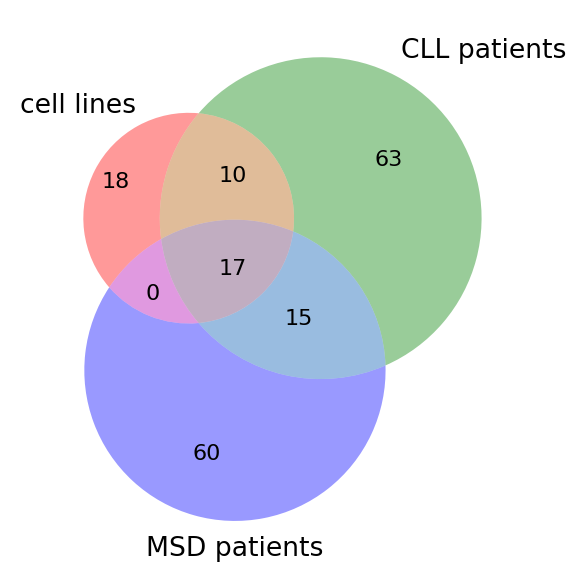

In [14]:
#venn diagram
plt.rcParams["figure.figsize"] = (3.5,3.5)
from matplotlib_venn import venn3
# subsets: A/B/AB/C/AC/AB/ABC
st='3AS'
sets=[set(res[ds].loc[(res[ds].splice_type==st) & (res[ds].padj<.1),'gene']) for ds in ["CL","CLL","MDS","all"]]
num_elem=[len(sets[0]-sets[1]-sets[2]),len(sets[1]-sets[0]-sets[2]), len(sets[0].intersection(sets[1])-sets[2]),
          len(sets[2]-sets[1]-sets[0]),len(sets[0].intersection(sets[2])-sets[0]),
          len(sets[2].intersection(sets[1])-sets[0]),len(sets[0].intersection(sets[1]).intersection(sets[2]))]
x=venn3(subsets = num_elem, set_labels=("cell lines","CLL patients","MSD patients"))
plt.savefig(f"{plot_path}/{project}_{date}_diffsplice_{version}_overlap_venn.pdf")

print(f'{len(sets[3]-sets[0]-sets[1]-sets[2]) } genes only detected with all samples')
print(f'{len(set.union(sets[0],sets[1],sets[2])-sets[3]) } genes not detected with all samples')
for i,n in enumerate(["celllines","CLL patients","MSD patients"]):
    print(f'The {n} have {len(sets[i]-sets[3])} sites not detected with all samples')
x

all
3AS
5AS
ES
ME


/pkg/python-3.10.8-0/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


IR


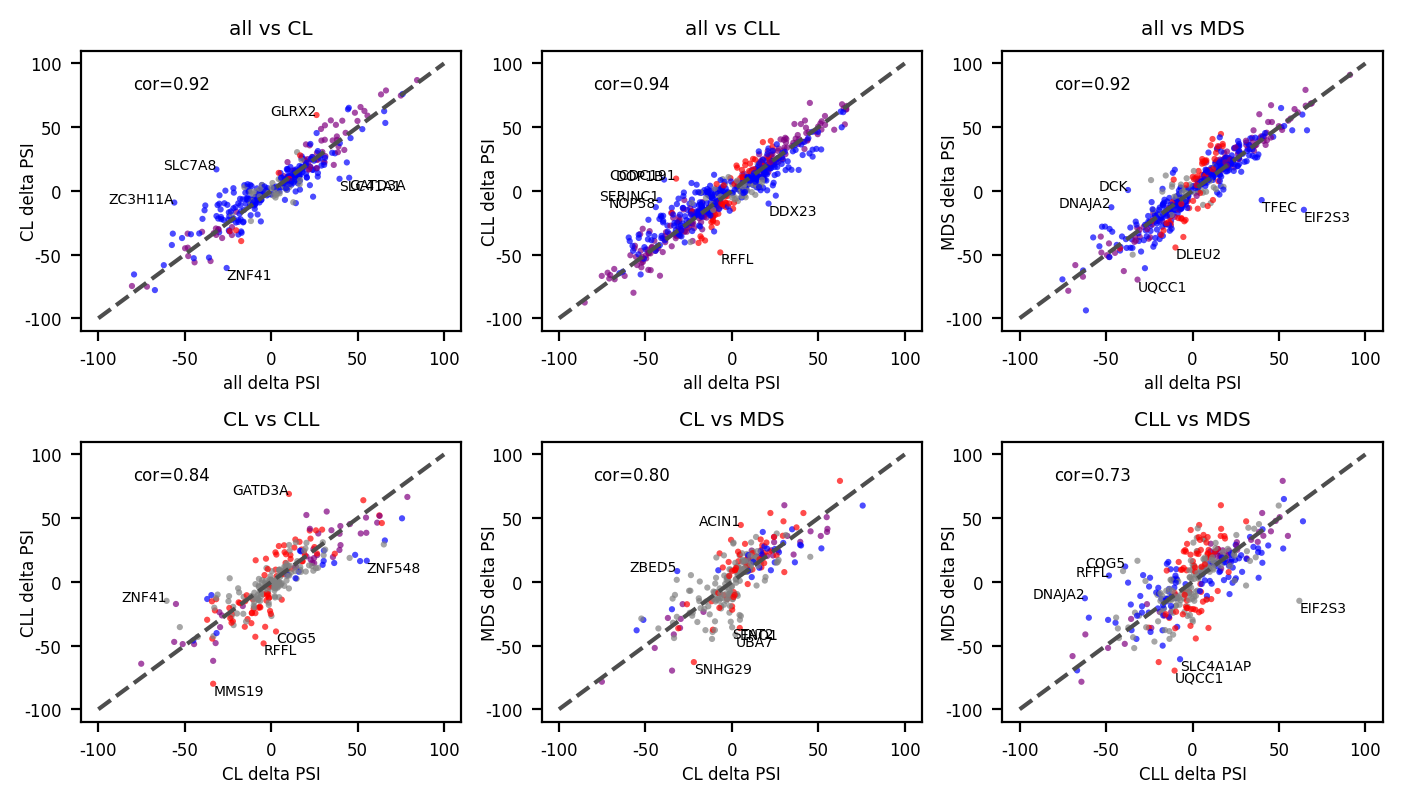

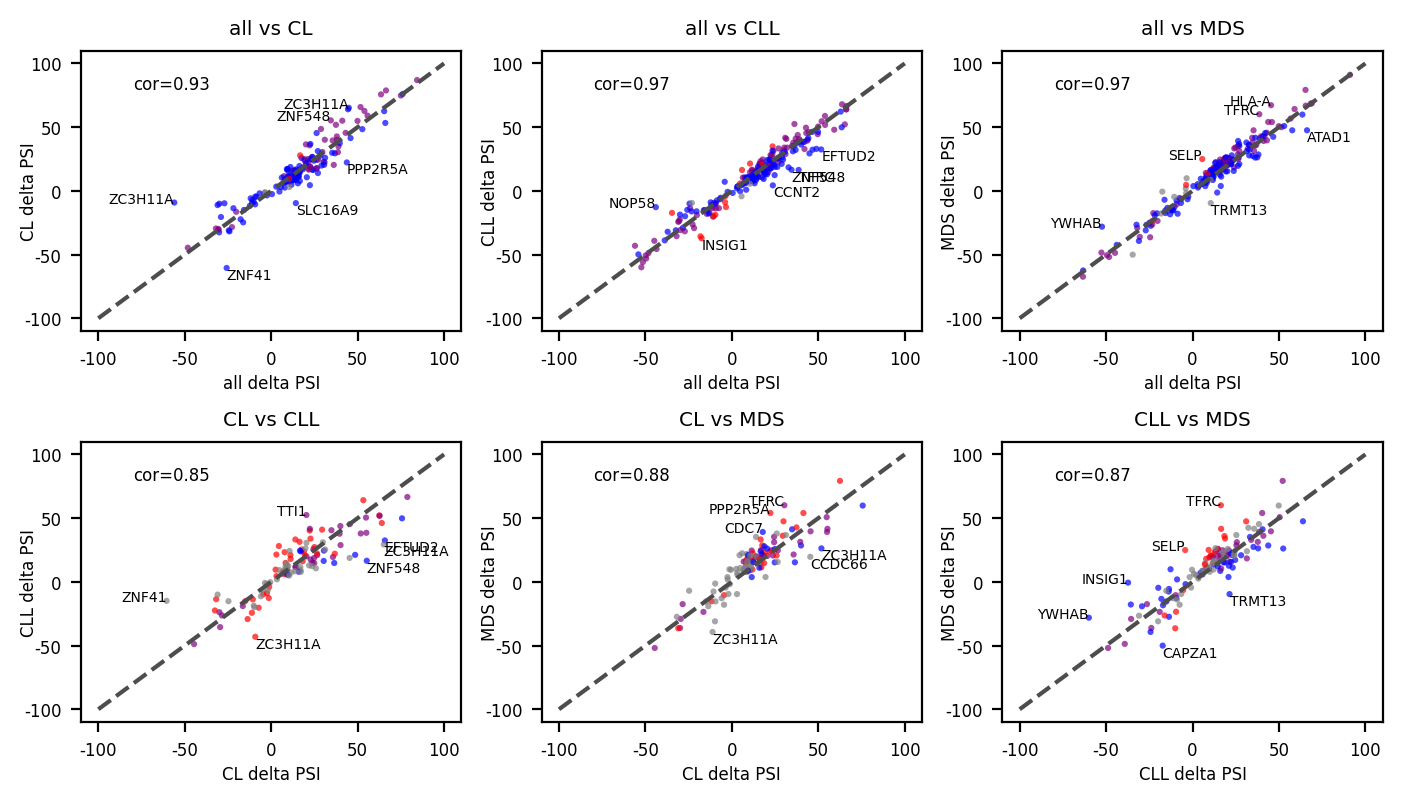

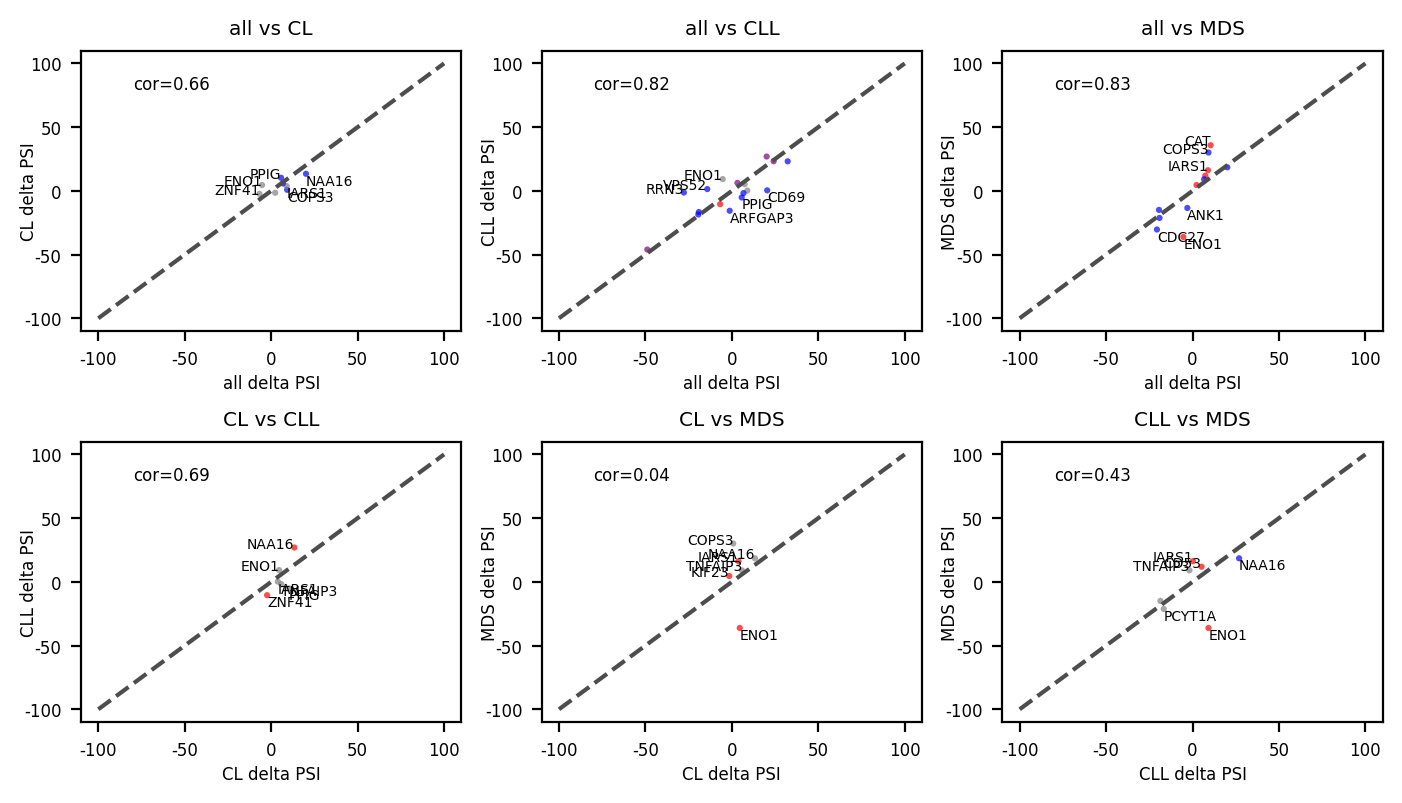

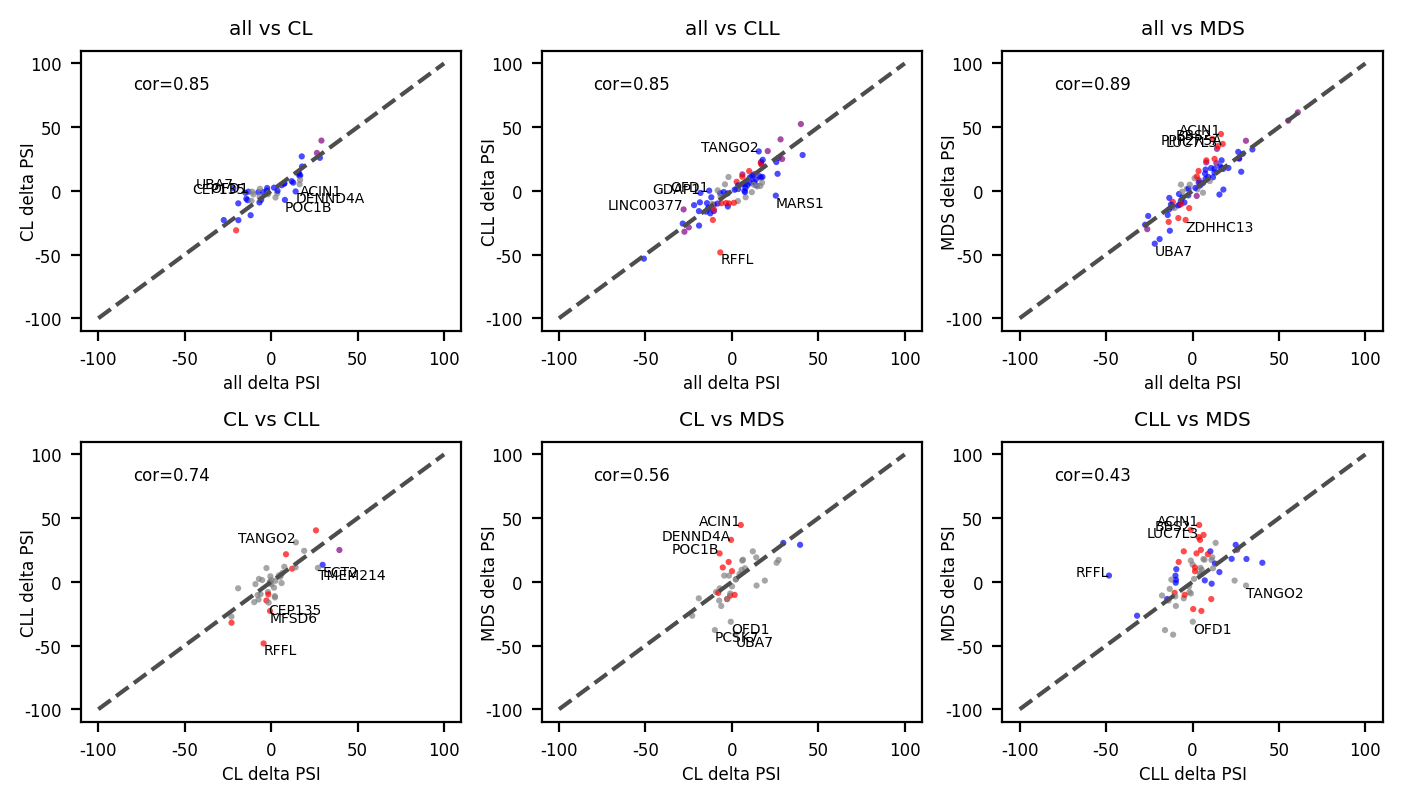

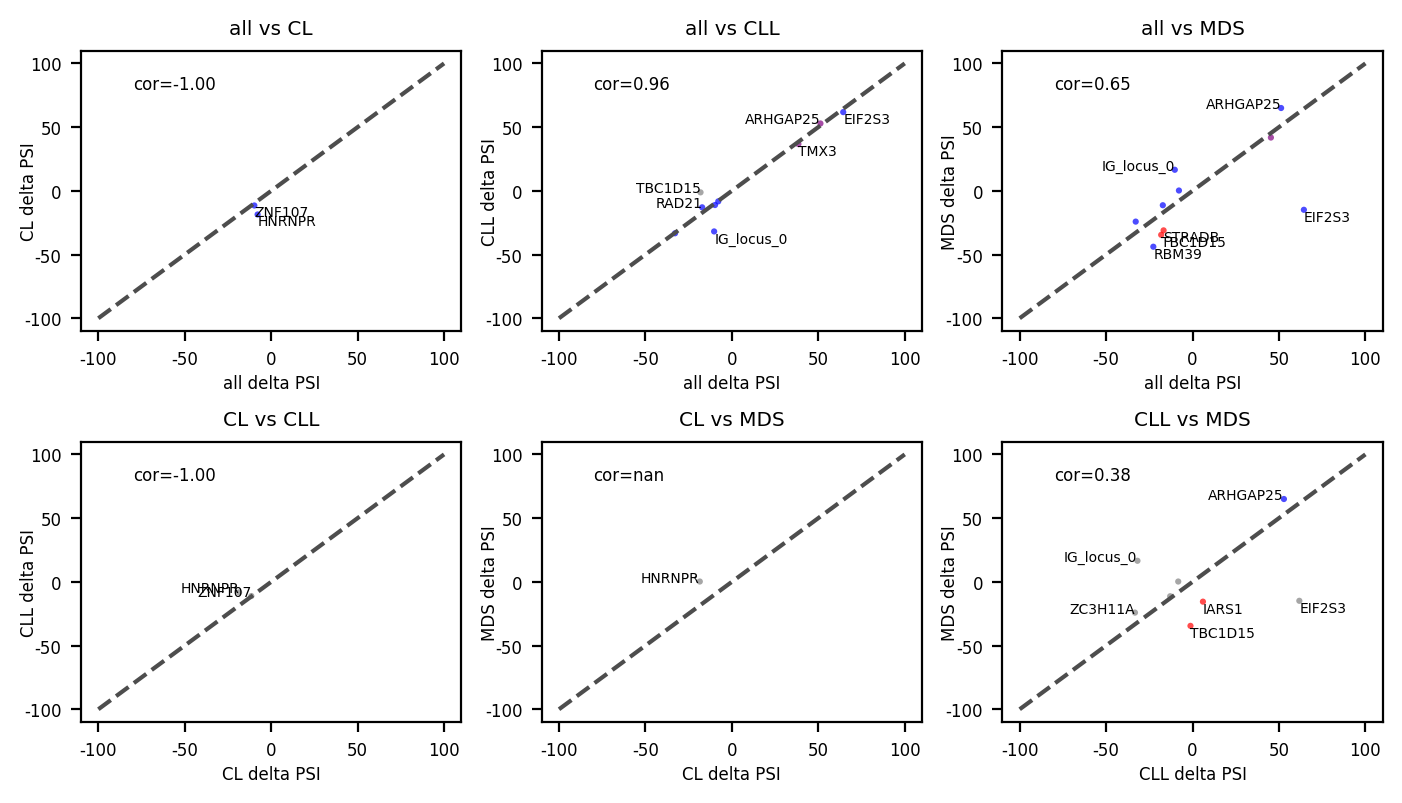

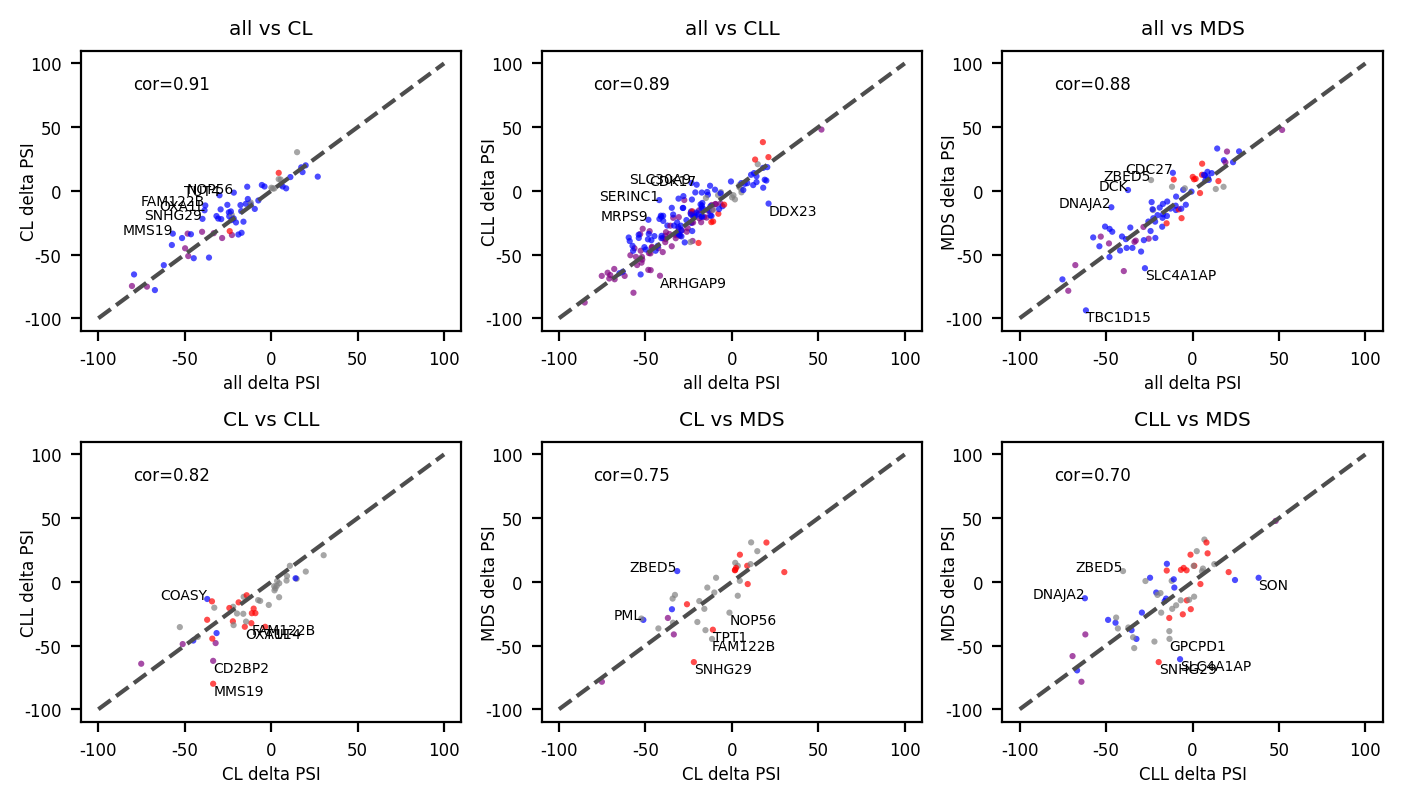

In [18]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (7,4)
#plt.rcParams["figure.figsize"] = (3.5,3.5)
plt.rcParams["font.size"]=6

colored=True

for st in ['all', '3AS', '5AS', 'ES', 'ME','IR']:
#for st in ['3AS']:
    print(st)
    if st=='all':
        st_idx=sig_union.index
    else:
        st_idx=sig_union.splice_type==st
    f, axs=plt.subplots(2,3)
    #f, axs=plt.subplots(2,2)
    #axs[0,0].set_visible(False)
    z=0
    for i,grA in enumerate(res):
        for j, grB in enumerate(res):
            #if i==0:
            #    continue
            if j>i:            
                #ax=axs.flatten()[-(z+1)]
                ax=axs.flatten()[z]
                z+=1                
                dPSIa=(sig_union.loc[st_idx,f'{grA}_mut_PSI']-sig_union.loc[st_idx,f'{grA}_wt_PSI'])*100
                dPSIb=(sig_union.loc[st_idx,f'{grB}_mut_PSI']-sig_union.loc[st_idx,f'{grB}_wt_PSI'])*100
                sigA=sig_union.loc[st_idx,f'{grA}_padj']<.1
                sigB=sig_union.loc[st_idx,f'{grB}_padj']<.1
                col=[['gray', 'blue', 'red', 'purple'][i] for i in sigA+2*sigB]
                #sns.regplot(x=dPSIa, y=dPSIb,  ax=ax,fit_reg=False, scatter_kws={'s':5})
                if colored:
                    ax.scatter(x=dPSIa, y=dPSIb,  s=5,c=col, alpha=.7,lw=0)
                else:
                    ax.scatter(x=dPSIa, y=dPSIb,  s=5, alpha=.5,lw=0)
                ax.set_title(f'{grA} vs {grB}')
                ax.set_xlabel(f'{grA} delta PSI',labelpad=2)
                ax.set_ylabel(f'{grB} delta PSI',labelpad=-5)
                ax.plot([-100,100], [-100,100], ls="--", c=".3")
                cor=dPSIa.corr( dPSIb)
                ax.text(-80,80,f'cor={cor:.2f}')
                idx_intersect=dPSIa.index.intersection(dPSIb.index)
                #for idx,gene in enumerate(sig_union.loc[st_idx,'gene']):#
                try:
                    th=sorted([v for v in (abs(dPSIa[idx]-dPSIb[idx]) for idx in idx_intersect) if not np.isnan(v)])[-6]
                except IndexError:
                    th=0
                for idx in idx_intersect:
                    if abs(dPSIa[idx]-dPSIb[idx])>=th:
                        gene=sig_union.loc[idx,'gene']
                        #print(gene)
                        if dPSIa[idx]>dPSIb[idx]:
                            ax.annotate(gene, [dPSIa[idx],dPSIb[idx]], va='top', size=5)
                        else:
                            ax.annotate(gene, [dPSIa[idx],dPSIb[idx]], ha='right', size=5)
    f.tight_layout()
    f.savefig(f'{plot_path}/{project}_{date}_diffsplice_{version}_{st}_{"color" if colored else ""}_overlap_correlation.pdf')
